In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt

In [2]:
train_dir = "/kaggle/input/brain-tumour-mri-data/Training"
test_dir = "/kaggle/input/brain-tumour-mri-data/Testing"

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
class2idx = {cls: i for i, cls in enumerate(classes)}

print("Classes:", classes)
print("Class to Index Mapping:", class2idx)
print("Train directory:", train_dir)
print("Test directory:", test_dir)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class to Index Mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Train directory: /kaggle/input/brain-tumour-mri-data/Training
Test directory: /kaggle/input/brain-tumour-mri-data/Testing


In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, base_dir, classes, transform=None):
        self.samples = []
        self.transform = transform
        for cls in classes:
            cls_dir = os.path.join(base_dir, cls)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                if img_path.lower().endswith(('.jpg', '.png', '.jpeg')):
                    self.samples.append((img_path, cls))
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, class2idx[label]

In [4]:
print(os.listdir("/kaggle/input/brain-tumour-mri-data/Training"))

['pituitary', 'notumor', 'meningioma', 'glioma']


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
batch_size = 32
num_epochs = 20

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Using device: cuda


In [15]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


full_train_dataset = datasets.ImageFolder("/kaggle/input/brain-tumour-mri-data/Training", transform=train_transform)
test_dataset = datasets.ImageFolder("/kaggle/input/brain-tumour-mri-data/Testing", transform=val_transform)


val_size = int(0.1 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
model = models.densenet121(pretrained=True)


num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, len(classes))

model = model.to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # lower LR for fine-tuning

In [18]:
best_acc = 0.0
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
  
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total * 100
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
    
   
    checkpoint_path = os.path.join(checkpoint_dir, f"brain_tumor_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), checkpoint_path)
    
 
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/brain_tumor_densenet_best.pth")
        print(f"✅ New best model saved at epoch {epoch+1} with accuracy {best_acc:.2f}%")

Epoch 1/20: 100%|██████████| 161/161 [01:20<00:00,  2.00it/s]


Epoch [1/20], Loss: 0.2562, Val Accuracy: 97.20%
✅ New best model saved at epoch 1 with accuracy 97.20%


Epoch 2/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [2/20], Loss: 0.0575, Val Accuracy: 97.02%


Epoch 3/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [3/20], Loss: 0.0269, Val Accuracy: 97.90%
✅ New best model saved at epoch 3 with accuracy 97.90%


Epoch 4/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [4/20], Loss: 0.0215, Val Accuracy: 97.20%


Epoch 5/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [5/20], Loss: 0.0149, Val Accuracy: 98.60%
✅ New best model saved at epoch 5 with accuracy 98.60%


Epoch 6/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [6/20], Loss: 0.0078, Val Accuracy: 98.95%
✅ New best model saved at epoch 6 with accuracy 98.95%


Epoch 7/20: 100%|██████████| 161/161 [01:19<00:00,  2.04it/s]


Epoch [7/20], Loss: 0.0147, Val Accuracy: 97.72%


Epoch 8/20: 100%|██████████| 161/161 [01:19<00:00,  2.02it/s]


Epoch [8/20], Loss: 0.0178, Val Accuracy: 98.07%


Epoch 9/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [9/20], Loss: 0.0098, Val Accuracy: 99.12%
✅ New best model saved at epoch 9 with accuracy 99.12%


Epoch 10/20: 100%|██████████| 161/161 [01:19<00:00,  2.02it/s]


Epoch [10/20], Loss: 0.0043, Val Accuracy: 98.42%


Epoch 11/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [11/20], Loss: 0.0029, Val Accuracy: 99.12%


Epoch 12/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [12/20], Loss: 0.0017, Val Accuracy: 98.95%


Epoch 13/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [13/20], Loss: 0.0025, Val Accuracy: 98.60%


Epoch 14/20: 100%|██████████| 161/161 [01:19<00:00,  2.04it/s]


Epoch [14/20], Loss: 0.0082, Val Accuracy: 98.07%


Epoch 15/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [15/20], Loss: 0.0200, Val Accuracy: 98.60%


Epoch 16/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [16/20], Loss: 0.0161, Val Accuracy: 98.95%


Epoch 17/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [17/20], Loss: 0.0035, Val Accuracy: 98.25%


Epoch 18/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [18/20], Loss: 0.0107, Val Accuracy: 98.77%


Epoch 19/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [19/20], Loss: 0.0028, Val Accuracy: 98.95%


Epoch 20/20: 100%|██████████| 161/161 [01:19<00:00,  2.03it/s]


Epoch [20/20], Loss: 0.0068, Val Accuracy: 98.25%


/tmp/ipykernel_36/305649754.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


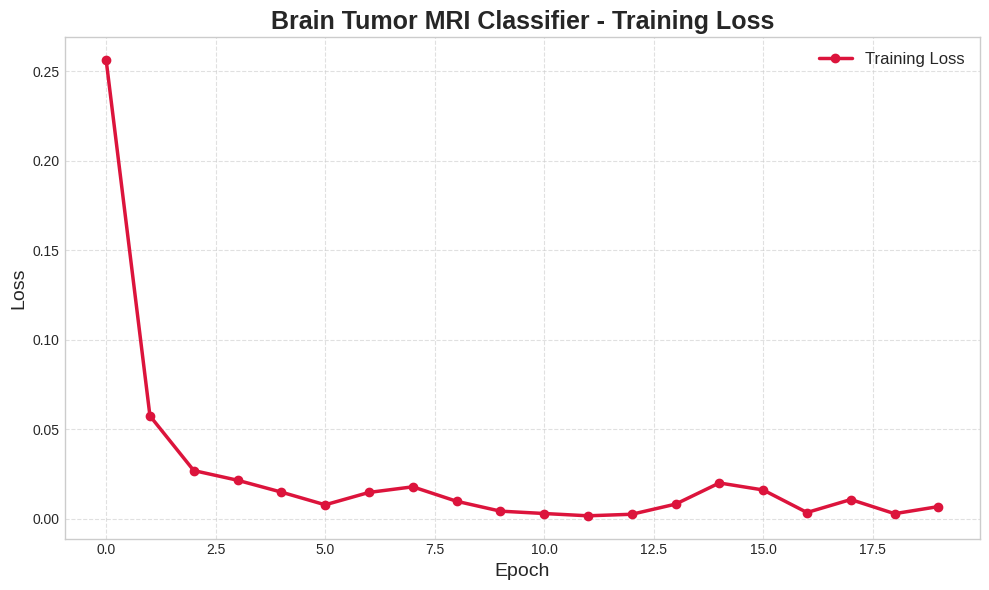

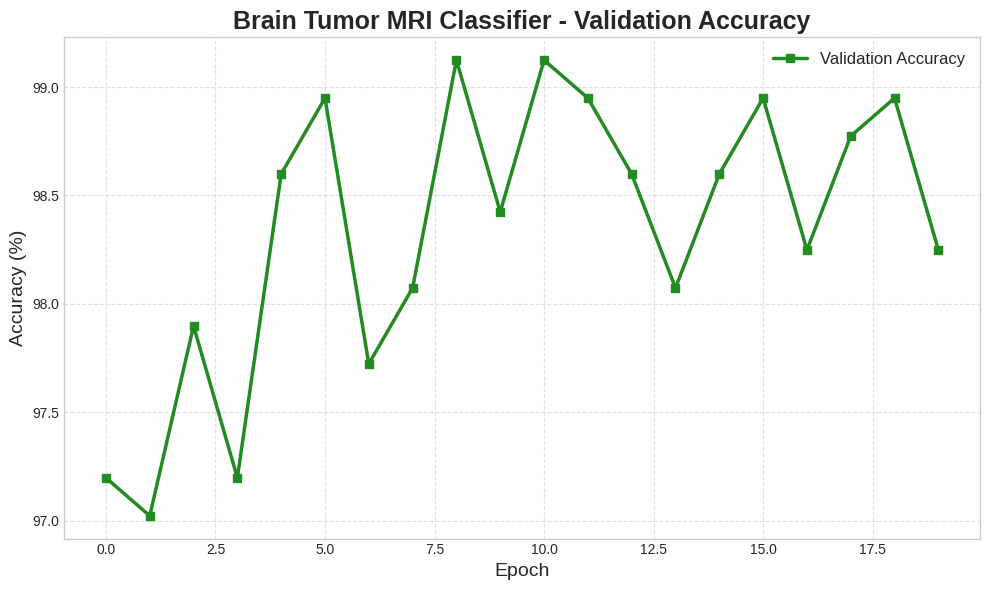

In [19]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


plt.figure(figsize=(10,6))
plt.plot(train_losses, color='crimson', linewidth=2.5, marker='o', markersize=6, label='Training Loss')
plt.title("Brain Tumor MRI Classifier - Training Loss", fontsize=18, fontweight='bold')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.plot(val_accuracies, color='forestgreen', linewidth=2.5, marker='s', markersize=6, label='Validation Accuracy')
plt.title("Brain Tumor MRI Classifier - Validation Accuracy", fontsize=18, fontweight='bold')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()